# Guía 5 - Filtros

## Ejercicio 1

Diseñe un filtro FIR mediante el método de ventanas (implementado por usted mismo), que permita eliminar el ruido de línea en una señal que fue muestreada a 300 Hz. Compare los resultados obtenidos con diferentes ventanas de truncado y diferentes cantidades de muestras en la respuesta al impulso.

### Solución

Para crear un filtro FIR, debemos seguir los pasos:
1. Definir frecuencias que se desea eliminar: pasa bajo $[0,f]$, pasa alto $[f,f_m]$, pasa banda $[f_1,f_2]$, rechaza banda $[0,f_1)(f_2,f_m]$
2. Antitransformar
3. Aplicar ventana de N muestras (cualquiera)
4. Aplicar desplazamiento de $\frac{N-1}{2}$ muestras. Para esto utilizar la propiedad de retardo de la TDF
$$x[n-i] \xLeftrightarrow{\mathcal{F}} X[k]e^{-j\omega i}$$
Obviamente vamos a aplicarlo antes de antitransformar, pero se menciona aca para que se entienda el por qué.

5. Obtener respuesta al impulso

#### Filtro rechaza banda

/home/lucas/.local/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/lucas/.local/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


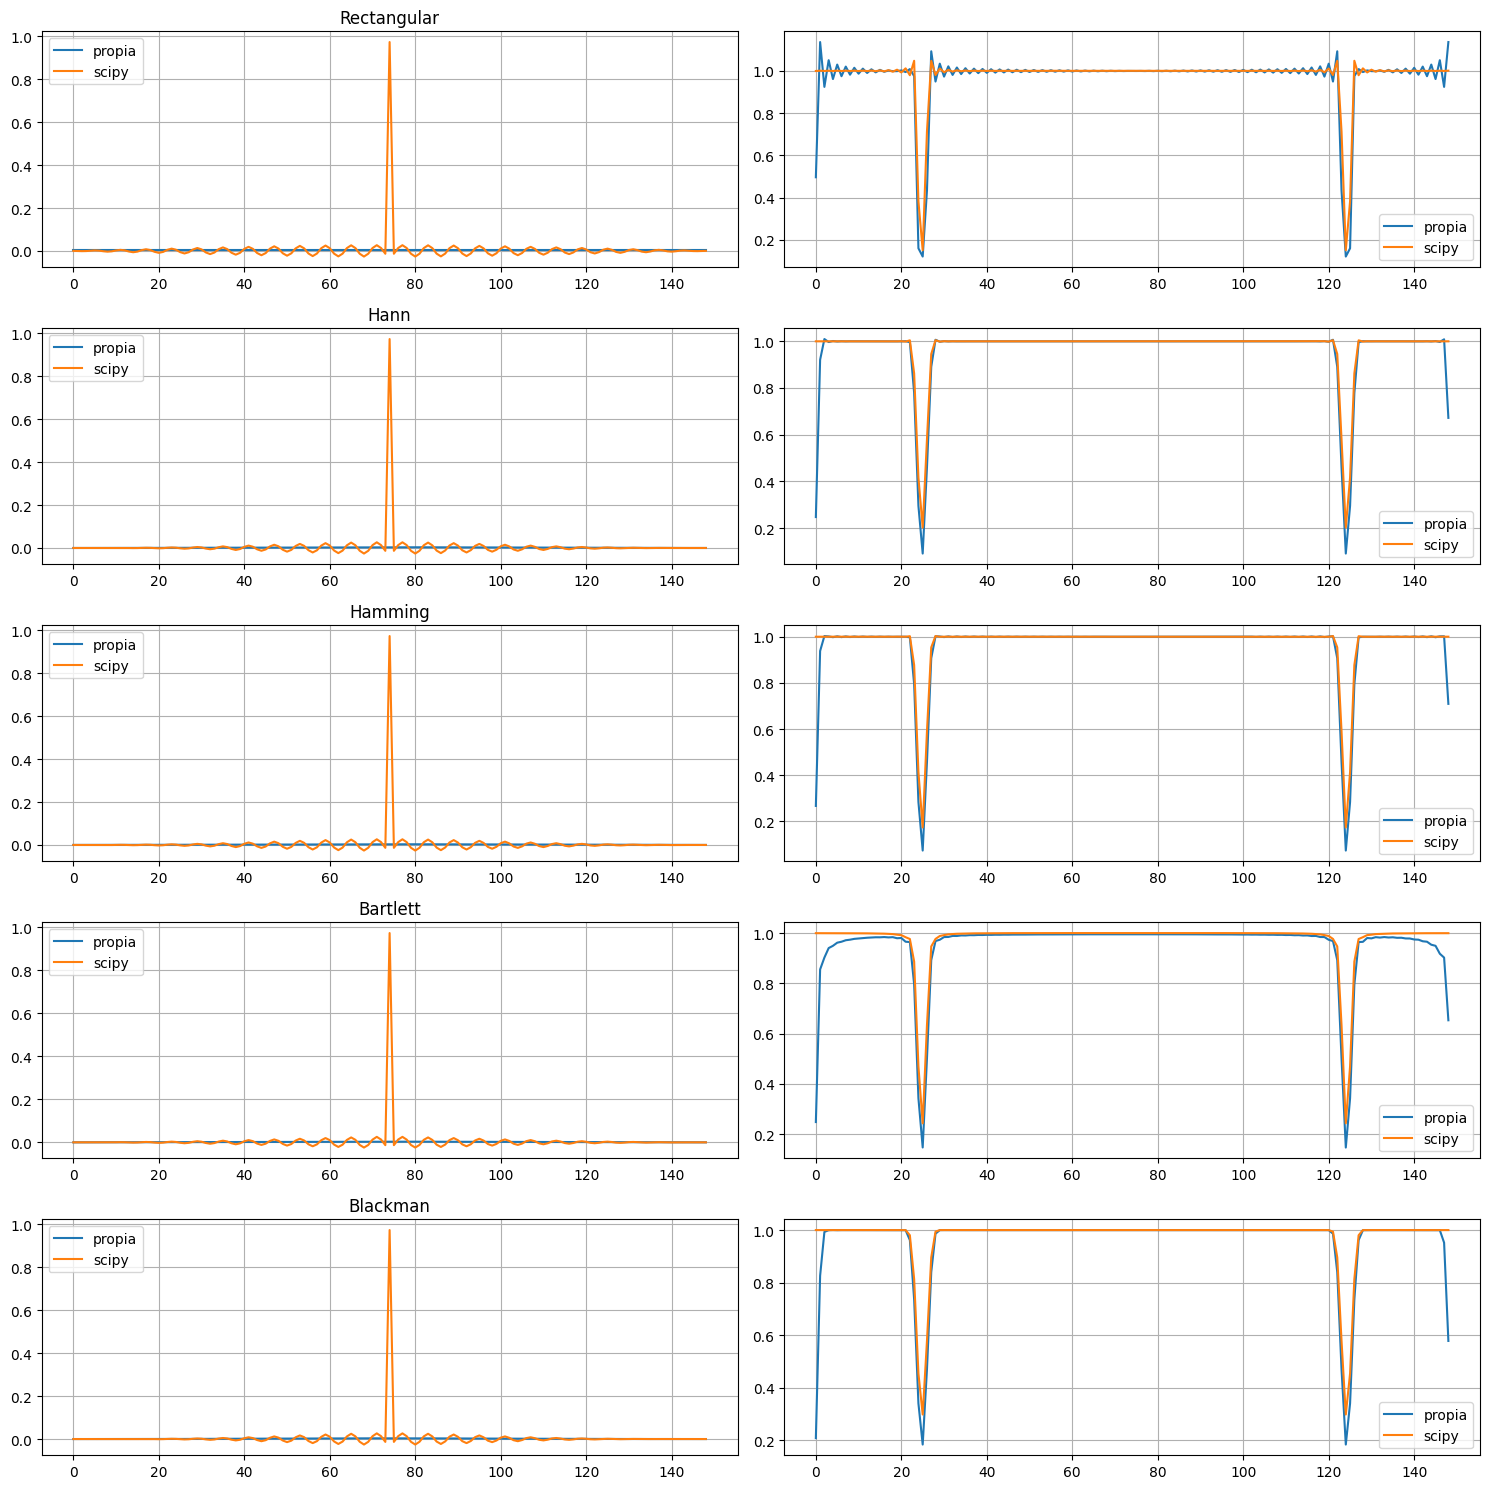

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin

def rectangular(s,Nini,Nfin):
    '''Ventana rectangular aplicada a s entre las muestras Nini y Nfin'''
    w = np.ones(Nfin-Nini)
    if Nini > 0:
        w = np.concatenate([np.zeros(Nini-1),w])
    if Nfin < len(s):
        w = np.concatenate([w,np.zeros(len(s)-len(w))])

    return np.multiply(w,s)

def hann(s,Nini,Nfin):
    '''Ventana de Hann aplicada a s entre las muestras Nini y Nfin'''
    N = Nfin-Nini
    n = np.linspace(0,N,N)

    aux = 2*np.pi/N
    w = [0.5 for _ in range(N)] - 0.5 * np.cos(aux*n)
    if Nini > 0:
        w = np.concatenate([np.zeros(Nini-1),w])
    if Nfin < len(s):
        w = np.concatenate([w,np.zeros(len(s)-len(w))])

    return np.multiply(w,s)

def hamming(s,Nini,Nfin):
    '''Ventana de Hamming aplicada a s entre las muestras Nini y Nfin'''
    N = Nfin-Nini
    n = np.linspace(0,N,N)

    aux = 2*np.pi/N
    w = [27/50 for _ in range(N)] - 23/50 * np.cos(aux*n)
    if Nini > 0:
        w = np.concatenate([np.zeros(Nini-1),w])
    if Nfin < len(s):
        w = np.concatenate([w,np.zeros(len(s)-len(w))])

    return np.multiply(w,s)

def bartlett(s,Nini,Nfin):
    '''Ventana de Bartlett aplicada a s entre las muestras Nini y Nfin'''
    N = Nfin-Nini
    n = np.linspace(0,N,N)

    aux = 2.0/N
    w = np.where(np.less_equal(n,N/2.0),n*aux,[2 for _ in range(N)] - n*aux)
    if Nini > 0:
        w = np.concatenate([np.zeros(Nini-1),w])
    if Nfin < len(s):
        w = np.concatenate([w,np.zeros(len(s)-len(w))])

    return np.multiply(w,s)

def blackman(s,Nini,Nfin):
    '''Ventana de Blackman aplicada a s entre las muestras Nini y Nfin'''
    N = Nfin-Nini
    n = np.linspace(0,N,N)

    aux = 2*np.pi/N
    w = [21/50 for _ in range(N)] - 0.5*np.cos(aux*n) + (2/25)*np.cos(2*aux*n)
    if Nini > 0:
        w = np.concatenate([np.zeros(Nini-1),w])
    if Nfin < len(s):
        w = np.concatenate([w,np.zeros(len(s)-len(w))])

    return np.multiply(w,s)

def retardar(X,i):
    N = len(X)
    k = np.arange(N)
    exp = np.exp(-2j*np.pi*k*i/N)
    Xret = X*exp
    return Xret

def rechazabandaFreq(fm,f1,f2):
    '''genera la respuesta en frecuencia para un filtro pasa alto de frecuencia muestreal fm para frecuencias >= f'''
    k = np.arange(fm)
    H = np.where(np.logical_or(np.less(k,f1),np.greater(k,fm-f1)), 1, 0)
    H = np.where(np.logical_and(np.greater(k,f2),np.less(k,fm-f2)), 1, H)
    return H

def FIRRechazaBanda(fm,f1,f2,N,W):
    '''Genera un h[n] de un filtro pasa banda para frecuencias f1 <= k <= f2, con duracion N muestras y aplicando la ventana W'''

    # Generar respuesta en frecuencia deseada
    X = rechazabandaFreq(fm,f1,f2)

    # Aplicar retardo
    X = retardar(X,N/2.0)   # Por alguna razon, (N-1)/2 rompe todo

    # Antitransformar
    x = np.fft.ifft(X)

    # Aplicar ventana
    x = W(x,0,N)

    # Devolver recortada
    return x[:N]

# Parametros
fm = 300
fmin = 48
fmax = 52
longitud = 149# Rechaza Banda

hrectangular = FIRRechazaBanda(fm,fmin,fmax,longitud,rectangular)
hhann = FIRRechazaBanda(fm,fmin,fmax,longitud,hann)
hhamming = FIRRechazaBanda(fm,fmin,fmax,longitud,hamming)
hbartlett = FIRRechazaBanda(fm,fmin,fmax,longitud,bartlett)
hblackman = FIRRechazaBanda(fm,fmin,fmax,longitud,blackman)

scipyhrectangular = firwin(longitud,[fmin,fmax],window='boxcar', fs=fm)
scipyhhann = firwin(longitud,[fmin,fmax],window='hann', fs=fm)
scipyhhamming = firwin(longitud,[fmin,fmax],window='hamming', fs=fm)
scipyhbartlett = firwin(longitud,[fmin,fmax],window='bartlett', fs=fm)
scipyhblackman = firwin(longitud,[fmin,fmax],window='blackman', fs=fm)

fig, ax = plt.subplots(5,2)
fig.set_figheight(15)
fig.set_figwidth(15)
for axi in ax:
    for axj in axi:
        axj.grid()

ax[0][0].plot(hrectangular, label='propia')
ax[0][0].plot(scipyhrectangular, label='scipy')
ax[0][0].set_title('Rectangular')
ax[0][0].legend(loc='upper left')
ax[1][0].plot(hhann, label='propia')
ax[1][0].plot(scipyhhann, label='scipy')
ax[1][0].set_title('Hann')
ax[1][0].legend(loc='upper left')
ax[2][0].plot(hhamming, label='propia')
ax[2][0].plot(scipyhhamming, label='scipy')
ax[2][0].set_title('Hamming')
ax[2][0].legend(loc='upper left')
ax[3][0].plot(hbartlett, label='propia')
ax[3][0].plot(scipyhbartlett, label='scipy')
ax[3][0].set_title('Bartlett')
ax[3][0].legend(loc='upper left')
ax[4][0].plot(hblackman, label='propia')
ax[4][0].plot(scipyhblackman, label='scipy')
ax[4][0].set_title('Blackman')
ax[4][0].legend(loc='upper left')

ax[0][1].plot(np.abs(np.fft.fft(hrectangular)), label='propia')
ax[0][1].plot(np.abs(np.fft.fft(scipyhrectangular)), label='scipy')
ax[0][1].legend(loc='lower right')
ax[1][1].plot(np.abs(np.fft.fft(hhann)), label='propia')
ax[1][1].plot(np.abs(np.fft.fft(scipyhhann)), label='scipy')
ax[1][1].legend(loc='lower right')
ax[2][1].plot(np.abs(np.fft.fft(hhamming)), label='propia')
ax[2][1].plot(np.abs(np.fft.fft(scipyhhamming)), label='scipy')
ax[2][1].legend(loc='lower right')
ax[3][1].plot(np.abs(np.fft.fft(hbartlett)), label='propia')
ax[3][1].plot(np.abs(np.fft.fft(scipyhbartlett)), label='scipy')
ax[3][1].legend(loc='lower right')
ax[4][1].plot(np.abs(np.fft.fft(hblackman)), label='propia')
ax[4][1].plot(np.abs(np.fft.fft(scipyhblackman)), label='scipy')
ax[4][1].legend(loc='lower right')
fig.tight_layout()

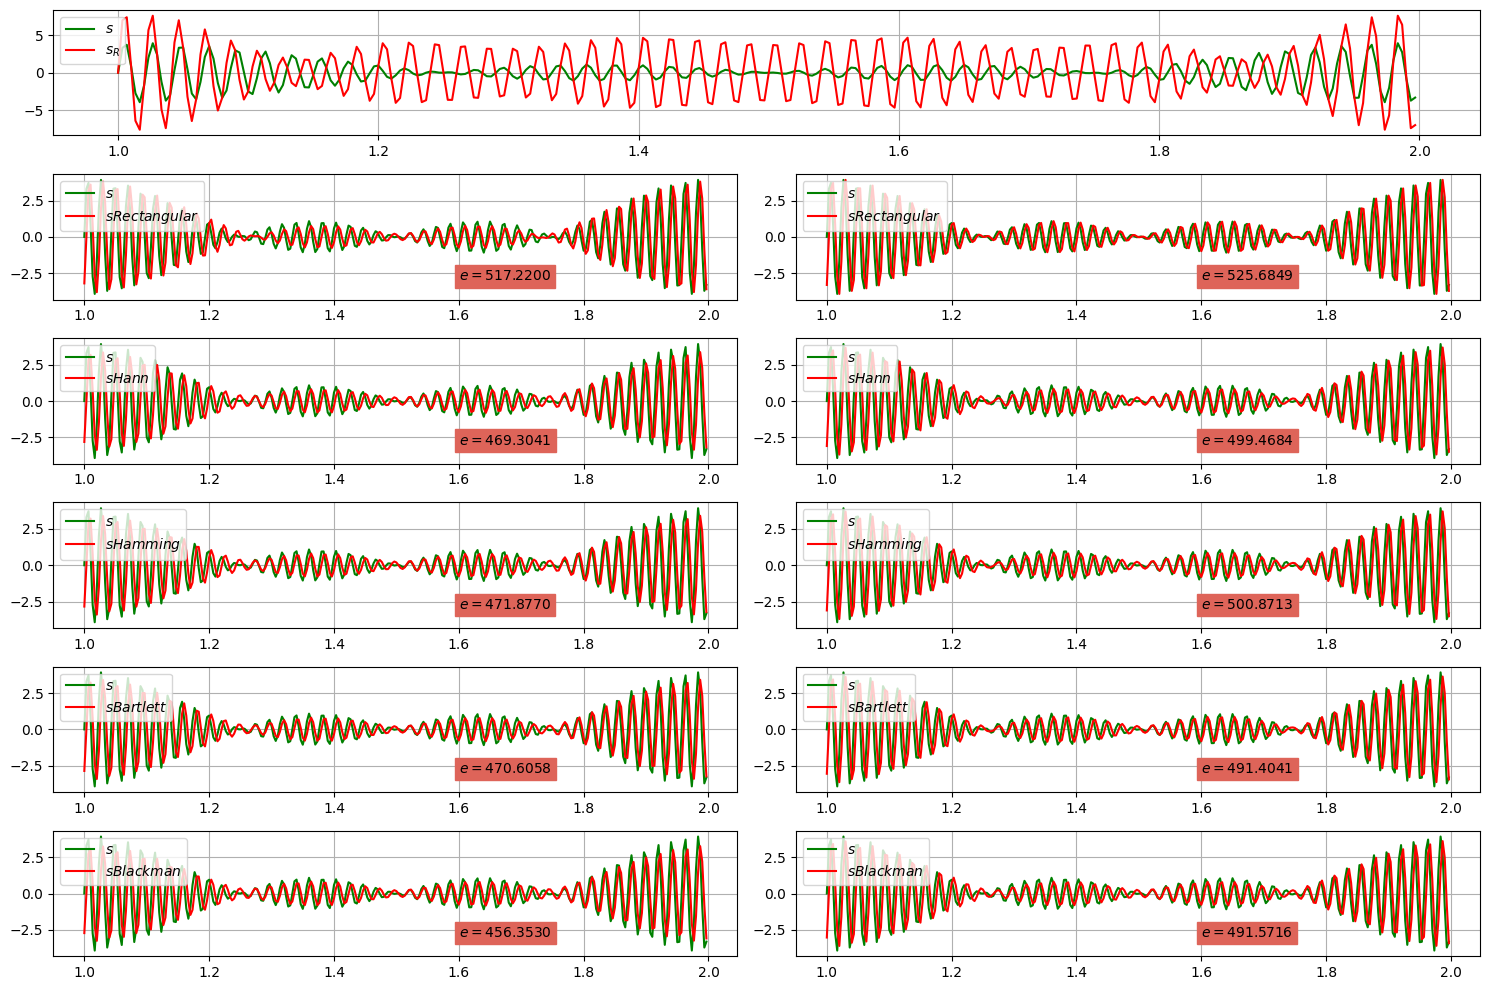

In [2]:
import random

def ECT(y,yapprox):
    return np.sum(np.power(y-yapprox,[2]*len(y)))

# Parametros
Tini = 0
Tfin = 5
fm = 300

# Generar senial con un ruido de 50Hz
t = np.linspace(Tini,Tfin,int(fm*(Tfin-Tini)), endpoint=False)

s = [0 for _ in range(len(t))]      # senial limpia
iRuido = random.random()*4+1        # intensidad del ruido de 50Hz
sr = iRuido*np.sin(2*np.pi*50*t)    # senial con ruido
for f in range(45,49):
    A = random.random()*4+1
    s += np.sin(2*np.pi*f*t)
    sr += np.sin(2*np.pi*f*t)

# Filtrar senial
filtroRectangular = FIRRechazaBanda(fm,49,51,150,rectangular)
filtroHann = FIRRechazaBanda(fm,49,51,150,hann)
filtroHamming = FIRRechazaBanda(fm,49,51,150,hamming)
filtroBartlett = FIRRechazaBanda(fm,49,51,150,bartlett)
filtroBlackman = FIRRechazaBanda(fm,49,51,150,blackman)
filtroRectangular2 = FIRRechazaBanda(fm,49,51,300,rectangular)
filtroHann2 = FIRRechazaBanda(fm,49,51,300,hann)
filtroHamming2 = FIRRechazaBanda(fm,49,51,300,hamming)
filtroBartlett2 = FIRRechazaBanda(fm,49,51,300,bartlett)
filtroBlackman2 = FIRRechazaBanda(fm,49,51,300,blackman)

sRectangular = np.convolve(s,filtroRectangular,mode='same')
sHann = np.convolve(s,filtroHann,mode='same')
sHamming = np.convolve(s,filtroHamming,mode='same')
sBartlett = np.convolve(s,filtroBartlett,mode='same')
sBlackman = np.convolve(s,filtroBlackman,mode='same')

sRectangular2 = np.convolve(s,filtroRectangular2,mode='same')
sHann2 = np.convolve(s,filtroHann2,mode='same')
sHamming2 = np.convolve(s,filtroHamming2,mode='same')
sBartlett2 = np.convolve(s,filtroBartlett2,mode='same')
sBlackman2 = np.convolve(s,filtroBlackman2,mode='same')

# Graficar
fig = plt.figure()
ax = [
    plt.subplot2grid([6,1],[0,0]),
    plt.subplot2grid([6,2],[1,0]),
    plt.subplot2grid([6,2],[1,1]),
    plt.subplot2grid([6,2],[2,0]),
    plt.subplot2grid([6,2],[2,1]),
    plt.subplot2grid([6,2],[3,0]),
    plt.subplot2grid([6,2],[3,1]),
    plt.subplot2grid([6,2],[4,0]),
    plt.subplot2grid([6,2],[4,1]),
    plt.subplot2grid([6,2],[5,0]),
    plt.subplot2grid([6,2],[5,1]),
]
fig.set_figheight(10)
fig.set_figwidth(15)
for axi in ax:
    axi.grid()

ax[0].plot(t[fm:2*fm],s[fm:2*fm],label='$s$',color='g')
ax[0].plot(t[fm:2*fm],sr[fm:2*fm],label='$s_R$',color='r')
ax[0].legend(loc='upper left')

ax[1].plot(t[fm:2*fm],s[fm:2*fm],label='$s$', color='g')
ax[1].plot(t[fm:2*fm],sRectangular[fm:2*fm],label='$sRectangular$', color='r')
ax[1].legend(loc='upper left')
ax[1].text(1.6, -3, "$e = %.4f$" % np.abs(ECT(s[fm:2*fm],sRectangular[fm:2*fm])),
    fontsize=10,
    transform=ax[1].transData,
    bbox=dict(boxstyle='square', color='#DE6459'))

ax[2].plot(t[fm:2*fm],s[fm:2*fm],label='$s$', color='g')
ax[2].plot(t[fm:2*fm],sRectangular2[fm:2*fm],label='$sRectangular$', color='r')
ax[2].legend(loc='upper left')
ax[2].text(1.6, -3, "$e = %.4f$" % np.abs(ECT(s[fm:2*fm],sRectangular2[fm:2*fm])),
    fontsize=10,
    transform=ax[2].transData,
    bbox=dict(boxstyle='square', color='#DE6459'))

ax[3].plot(t[fm:2*fm],s[fm:2*fm],label='$s$', color='g')
ax[3].plot(t[fm:2*fm],sHann[fm:2*fm],label='$sHann$', color='r')
ax[3].legend(loc='upper left')
ax[3].text(1.6, -3, "$e = %.4f$" % np.abs(ECT(s[fm:2*fm],sHann[fm:2*fm])),
    fontsize=10,
    transform=ax[3].transData,
    bbox=dict(boxstyle='square', color='#DE6459'))

ax[4].plot(t[fm:2*fm],s[fm:2*fm],label='$s$', color='g')
ax[4].plot(t[fm:2*fm],sHann2[fm:2*fm],label='$sHann$', color='r')
ax[4].legend(loc='upper left')
ax[4].text(1.6, -3, "$e = %.4f$" % np.abs(ECT(s[fm:2*fm],sHann2[fm:2*fm])),
    fontsize=10,
    transform=ax[4].transData,
    bbox=dict(boxstyle='square', color='#DE6459'))

ax[5].plot(t[fm:2*fm],s[fm:2*fm],label='$s$', color='g')
ax[5].plot(t[fm:2*fm],sHamming[fm:2*fm],label='$sHamming$', color='r')
ax[5].legend(loc='upper left')
ax[5].text(1.6, -3, "$e = %.4f$" % np.abs(ECT(s[fm:2*fm],sHamming[fm:2*fm])),
    fontsize=10,
    transform=ax[5].transData,
    bbox=dict(boxstyle='square', color='#DE6459'))

ax[6].plot(t[fm:2*fm],s[fm:2*fm],label='$s$', color='g')
ax[6].plot(t[fm:2*fm],sHamming2[fm:2*fm],label='$sHamming$', color='r')
ax[6].legend(loc='upper left')
ax[6].text(1.6, -3, "$e = %.4f$" % np.abs(ECT(s[fm:2*fm],sHamming2[fm:2*fm])),
    fontsize=10,
    transform=ax[6].transData,
    bbox=dict(boxstyle='square', color='#DE6459'))

ax[7].plot(t[fm:2*fm],s[fm:2*fm],label='$s$', color='g')
ax[7].plot(t[fm:2*fm],sBartlett[fm:2*fm],label='$sBartlett$', color='r')
ax[7].legend(loc='upper left')
ax[7].text(1.6, -3, "$e = %.4f$" % np.abs(ECT(s[fm:2*fm],sBartlett[fm:2*fm])),
    fontsize=10,
    transform=ax[7].transData,
    bbox=dict(boxstyle='square', color='#DE6459'))

ax[8].plot(t[fm:2*fm],s[fm:2*fm],label='$s$', color='g')
ax[8].plot(t[fm:2*fm],sBartlett2[fm:2*fm],label='$sBartlett$', color='r')
ax[8].legend(loc='upper left')
ax[8].text(1.6, -3, "$e = %.4f$" % np.abs(ECT(s[fm:2*fm],sBartlett2[fm:2*fm])),
    fontsize=10,
    transform=ax[8].transData,
    bbox=dict(boxstyle='square', color='#DE6459'))

ax[9].plot(t[fm:2*fm],s[fm:2*fm],label='$s$', color='g')
ax[9].plot(t[fm:2*fm],sBlackman[fm:2*fm],label='$sBlackman$', color='r')
ax[9].legend(loc='upper left')
ax[9].text(1.6, -3, "$e = %.4f$" % np.abs(ECT(s[fm:2*fm],sBlackman[fm:2*fm])),
    fontsize=10,
    transform=ax[9].transData,
    bbox=dict(boxstyle='square', color='#DE6459'))

ax[10].plot(t[fm:2*fm],s[fm:2*fm],label='$s$', color='g')
ax[10].plot(t[fm:2*fm],sBlackman2[fm:2*fm],label='$sBlackman$', color='r')
ax[10].legend(loc='upper left')
ax[10].text(1.6, -3, "$e = %.4f$" % np.abs(ECT(s[fm:2*fm],sBlackman2[fm:2*fm])),
    fontsize=10,
    transform=ax[10].transData,
    bbox=dict(boxstyle='square', color='#DE6459'))

fig.tight_layout()